In [1]:
import numpy as np
import pandas as pd
import os
import random
import tensorflow as tf
from CNN.utility import train_routine
from ds_creation.ds_utility import get_file_count, get_other_class
from ds_creation.split_config import phisical_split
from ds_creation.plot_utility import process_metrics
from prototypical.train.train_setup import train



SPLIT_PERC = {'train': 0.8, 'val': 0.2}
TEST_SPLIT = 0.2

DATA_DIR = os.path.join('data', 'mammals_calls', 'data')
TEST_DIR = os.path.join('data', 'mammals_calls_test')
SPLIT_DIR = os.path.join('data', 'mammals_calls', 'splits', 'custom')
AUDIO_DIR = os.path.join('data', 'audio')
MODELS_METRICS_DIR = os.path.join("models_metrics")
CNN_CACHE_DIR = os.path.join("data_cache", "CNN")

PATIENCE = 5
TO_TRAIN = False
FROM_START = True
os.makedirs(MODELS_METRICS_DIR, exist_ok=True)
os.makedirs(SPLIT_DIR, exist_ok=True)
    
h = 164
w = 397

seed = 2025
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Eseguo lo split fisico dei file solo la prima volta per dividere i file in train e test
FIRST_RUN = False
if FIRST_RUN:
    perc = 1-TEST_SPLIT
    phisical_split(DATA_DIR, perc)

2025-10-14 17:11:45.894340: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-14 17:11:45.953028: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-14 17:11:46.912393: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


GPUs found: 1
GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
GPUs found: 1
GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


Vengono divise le specie in tre gruppi:
* Quelle per il training della CNN, hanno più di 1000 sample, le restanti classi formeranno la classe other
* Quelle per il training della Prototypical, hanno tra i 1000 ed i 100 sample
* Quelle per il test della Prototypical, hanno meno di 100 sample 

Così vengono creati i file che serviranno alla prototypical per splittare le classi tra train, validation e test

In [ ]:
count_df = get_file_count(DATA_DIR)

CNN_training = count_df[count_df['file_count'] >= 1000]['species'].tolist()
proto_training = count_df[(count_df['file_count'] <= 1000) & (count_df['file_count'] >= 100)]['species'].tolist()
proto_test = count_df[count_df['file_count'] < 100]['species'].tolist()

random.shuffle(proto_training)
split_idx = int(len(proto_training) * SPLIT_PERC['train'])
proto_train = proto_training[:split_idx]
proto_val = proto_training[split_idx:]

with open(os.path.join(SPLIT_DIR, 'test.txt'), 'w') as f:
    for species in proto_test:
        f.write(f"{species}\n")
with open(os.path.join(SPLIT_DIR, 'train.txt'), 'w') as f:
    for species in proto_train:
        f.write(f"{species}\n")
with open(os.path.join(SPLIT_DIR, 'val.txt'), 'w') as f:
    for species in proto_val:
        f.write(f"{species}\n")



Viene fisicamente generata la classe other, contenente i files di tutte le altre classi che hanno meno di 1000 sample.
Viene quindi avviato il training della CNN su queste classi con uno split train/val 80/20 per stabilire il numero di epoche ottimale per l'addestramento.

In [3]:
count_df_truncated = get_file_count(DATA_DIR)
count_df_truncated = count_df_truncated[count_df_truncated['file_count'] < 999]

other_species_list = count_df_truncated['species'].tolist()
print(f'Other total files: {count_df_truncated["file_count"].sum()}, species count: {count_df_truncated.shape}, species: {other_species_list}')
get_other_class(DATA_DIR, other_species_list)

count_df = get_file_count(DATA_DIR)

Other total files: 6000, species count: (39, 2), species: ['Common_Dolphin', 'White-sided_Dolphin', 'Walrus', 'Clymene_Dolphin', "Fraser's_Dolphin", 'False_Killer_Whale', 'Striped_Dolphin', 'West_Indian_Manatee', 'Ross_Seal', 'Northern_Right_Whale', "Grampus,_Risso's_Dolphin", 'Harbor_Porpoise', 'Minke_Whale', 'Atlantic_Spotted_Dolphin', 'Dusky_Dolphin', 'Long_Beaked_(Pacific)_Common_Dolphin', 'Leopard_Seal', 'Beluga,_White_Whale', 'Melon_Headed_Whale', 'White-beaked_Dolphin', 'Gray_Whale', 'Harp_Seal', 'Southern_Right_Whale', 'Boutu,_Amazon_River_Dolphin', 'Ribbon_Seal', "Heaviside's_Dolphin", "Dall's_Porpoise", 'Rough-Toothed_Dolphin', 'Spotted_Seal', 'Irawaddy_Dolphin', 'Narwhal', 'Ringed_Seal', 'Juan_Fernandez_Fur_Seal', 'Tucuxi_Dolphin', 'Hooded_Seal', 'Sea_Otter', 'Finless_Porpoise', 'Steller_Sea_Lion', 'New_Zealand_Fur_Seal']


In [4]:
other_ds, history = train_routine(count_df, PATIENCE, SPLIT_PERC, DATA_DIR, (w, h), (0, 0), cardinality=1000, subfolder='14-10_training', from_start=FROM_START, to_train=True)

Total classes found: 13


Found 70114 files belonging to 13 classes.
Using 56092 files for training.


I0000 00:00:1760456910.933411   75734 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18314 MB memory:  -> device: 0, name: NVIDIA RTX 4000 Ada Generation, pci bus id: 0000:18:00.0, compute capability: 8.9


Found 70114 files belonging to 13 classes.
Using 14022 files for validation.
training
Epoch 1/50


2025-10-14 15:48:37.179239: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f297c007de0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-14 15:48:37.179284: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA RTX 4000 Ada Generation, Compute Capability 8.9
2025-10-14 15:48:37.516521: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-14 15:48:38.271537: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91301


   6/3506 ━━━━━━━━━━━━━━━━━━━━ 1:22 24ms/step - accuracy: 0.0267 - loss: 3.9561 - total: 56.0000 - tp_hm: 1.6667       

I0000 00:00:1760456923.757353   75991 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3506/3506 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5686 - loss: 1.0293 - total: 28055.9980 - tp_hm: 17709.5078

2025-10-14 15:50:28.363030: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


3506/3506 ━━━━━━━━━━━━━━━━━━━━ 114s 30ms/step - accuracy: 0.7013 - loss: 0.6604 - total: 56092.0000 - tp_hm: 39337.0000 - val_accuracy: 0.8276 - val_loss: 0.4462 - val_total: 14022.0000 - val_tp_hm: 11605.0000 - val_confusion_matrix: 82.9704
Epoch 2/50
3506/3506 ━━━━━━━━━━━━━━━━━━━━ 94s 27ms/step - accuracy: 0.8526 - loss: 0.3199 - total: 56092.0000 - tp_hm: 47823.0000 - val_accuracy: 0.8582 - val_loss: 0.3978 - val_total: 14022.0000 - val_tp_hm: 12034.0000 - val_confusion_matrix: 82.9704
Epoch 3/50
   4/3506 ━━━━━━━━━━━━━━━━━━━━ 1:09 20ms/step - accuracy: 0.9740 - loss: 0.1116 - total: 40.0000 - tp_hm: 38.5000

2025-10-14 15:52:02.906635: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


3506/3506 ━━━━━━━━━━━━━━━━━━━━ 95s 27ms/step - accuracy: 0.8812 - loss: 0.2589 - total: 56092.0000 - tp_hm: 49430.0000 - val_accuracy: 0.8430 - val_loss: 0.4351 - val_total: 14022.0000 - val_tp_hm: 11821.0000 - val_confusion_matrix: 82.9704
Epoch 4/50
3506/3506 ━━━━━━━━━━━━━━━━━━━━ 95s 27ms/step - accuracy: 0.8952 - loss: 0.2303 - total: 56092.0000 - tp_hm: 50215.0000 - val_accuracy: 0.8944 - val_loss: 0.2527 - val_total: 14022.0000 - val_tp_hm: 12541.0000 - val_confusion_matrix: 82.9704
Epoch 5/50
   4/3506 ━━━━━━━━━━━━━━━━━━━━ 1:08 19ms/step - accuracy: 0.8997 - loss: 0.1833 - total: 40.0000 - tp_hm: 36.2500

2025-10-14 15:55:12.345600: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


3506/3506 ━━━━━━━━━━━━━━━━━━━━ 94s 27ms/step - accuracy: 0.9023 - loss: 0.2150 - total: 56092.0000 - tp_hm: 50613.0000 - val_accuracy: 0.8955 - val_loss: 0.2907 - val_total: 14022.0000 - val_tp_hm: 12557.0000 - val_confusion_matrix: 82.9704
Epoch 6/50
3506/3506 ━━━━━━━━━━━━━━━━━━━━ 94s 27ms/step - accuracy: 0.9072 - loss: 0.2007 - total: 56092.0000 - tp_hm: 50885.0000 - val_accuracy: 0.9137 - val_loss: 0.2354 - val_total: 14022.0000 - val_tp_hm: 12812.0000 - val_confusion_matrix: 82.9704
Epoch 7/50
3506/3506 ━━━━━━━━━━━━━━━━━━━━ 94s 27ms/step - accuracy: 0.9106 - loss: 0.1927 - total: 56092.0000 - tp_hm: 51080.0000 - val_accuracy: 0.8497 - val_loss: 0.4935 - val_total: 14022.0000 - val_tp_hm: 11915.0000 - val_confusion_matrix: 82.9704
Epoch 8/50
3506/3506 ━━━━━━━━━━━━━━━━━━━━ 94s 27ms/step - accuracy: 0.9135 - loss: 0.1862 - total: 56092.0000 - tp_hm: 51242.0000 - val_accuracy: 0.9145 - val_loss: 0.2527 - val_total: 14022.0000 - val_tp_hm: 12823.0000 - val_confusion_matrix: 82.9704
Epo

2025-10-14 16:01:28.704002: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


3506/3506 ━━━━━━━━━━━━━━━━━━━━ 95s 27ms/step - accuracy: 0.9151 - loss: 0.1797 - total: 56092.0000 - tp_hm: 51332.0000 - val_accuracy: 0.9126 - val_loss: 0.2446 - val_total: 14022.0000 - val_tp_hm: 12797.0000 - val_confusion_matrix: 82.9704
Epoch 10/50
3506/3506 ━━━━━━━━━━━━━━━━━━━━ 94s 27ms/step - accuracy: 0.9171 - loss: 0.1749 - total: 56092.0000 - tp_hm: 51441.0000 - val_accuracy: 0.9148 - val_loss: 0.2375 - val_total: 14022.0000 - val_tp_hm: 12828.0000 - val_confusion_matrix: 82.9704
Epoch 11/50
3506/3506 ━━━━━━━━━━━━━━━━━━━━ 95s 27ms/step - accuracy: 0.9180 - loss: 0.1736 - total: 56092.0000 - tp_hm: 51495.0000 - val_accuracy: 0.9076 - val_loss: 0.2667 - val_total: 14022.0000 - val_tp_hm: 12727.0000 - val_confusion_matrix: 82.9704
Epoch 12/50
3506/3506 ━━━━━━━━━━━━━━━━━━━━ 94s 27ms/step - accuracy: 0.9201 - loss: 0.1710 - total: 56092.0000 - tp_hm: 51613.0000 - val_accuracy: 0.8883 - val_loss: 0.3484 - val_total: 14022.0000 - val_tp_hm: 12456.0000 - val_confusion_matrix: 82.9704


{'accuracy': [0.7012943029403687, 0.8525815010070801, 0.8812308311462402, 0.8952257037162781, 0.9023211598396301, 0.9071703553199768, 0.9106467962265015, 0.9135348796844482, 0.9151394367218018, 0.917082667350769, 0.9180453419685364, 0.920149028301239, 0.9213078618049622, 0.9209156632423401, 0.9224666357040405], 'loss': [0.6604360342025757, 0.3199392855167389, 0.2589353621006012, 0.23033396899700165, 0.21498188376426697, 0.20068314671516418, 0.19270887970924377, 0.18616101145744324, 0.17968949675559998, 0.17492114007472992, 0.17360548675060272, 0.1710100919008255, 0.17113500833511353, 0.16437163949012756, 0.16219264268875122], 'total': [56092.0, 56092.0, 56092.0, 56092.0, 56092.0, 56092.0, 56092.0, 56092.0, 56092.0, 56092.0, 56092.0, 56092.0, 56092.0, 56092.0, 56092.0], 'tp_hm': [39337.0, 47823.0, 49430.0, 50215.0, 50613.0, 50885.0, 51080.0, 51242.0, 51332.0, 51441.0, 51495.0, 51613.0, 51678.0, 51656.0, 51743.0], 'val_accuracy': [0.8276280164718628, 0.8582227826118469, 0.843032360076904

In [5]:
best_epoch = np.argmax(history.history['val_accuracy']) + 1
print(f'Best epoch: {best_epoch}, val_accuracy: {history.history["val_accuracy"][best_epoch-1]}, accuracy: {history.history["accuracy"][best_epoch-1]}')

Best epoch: 10, val_accuracy: 0.9148480892181396, accuracy: 0.917082667350769


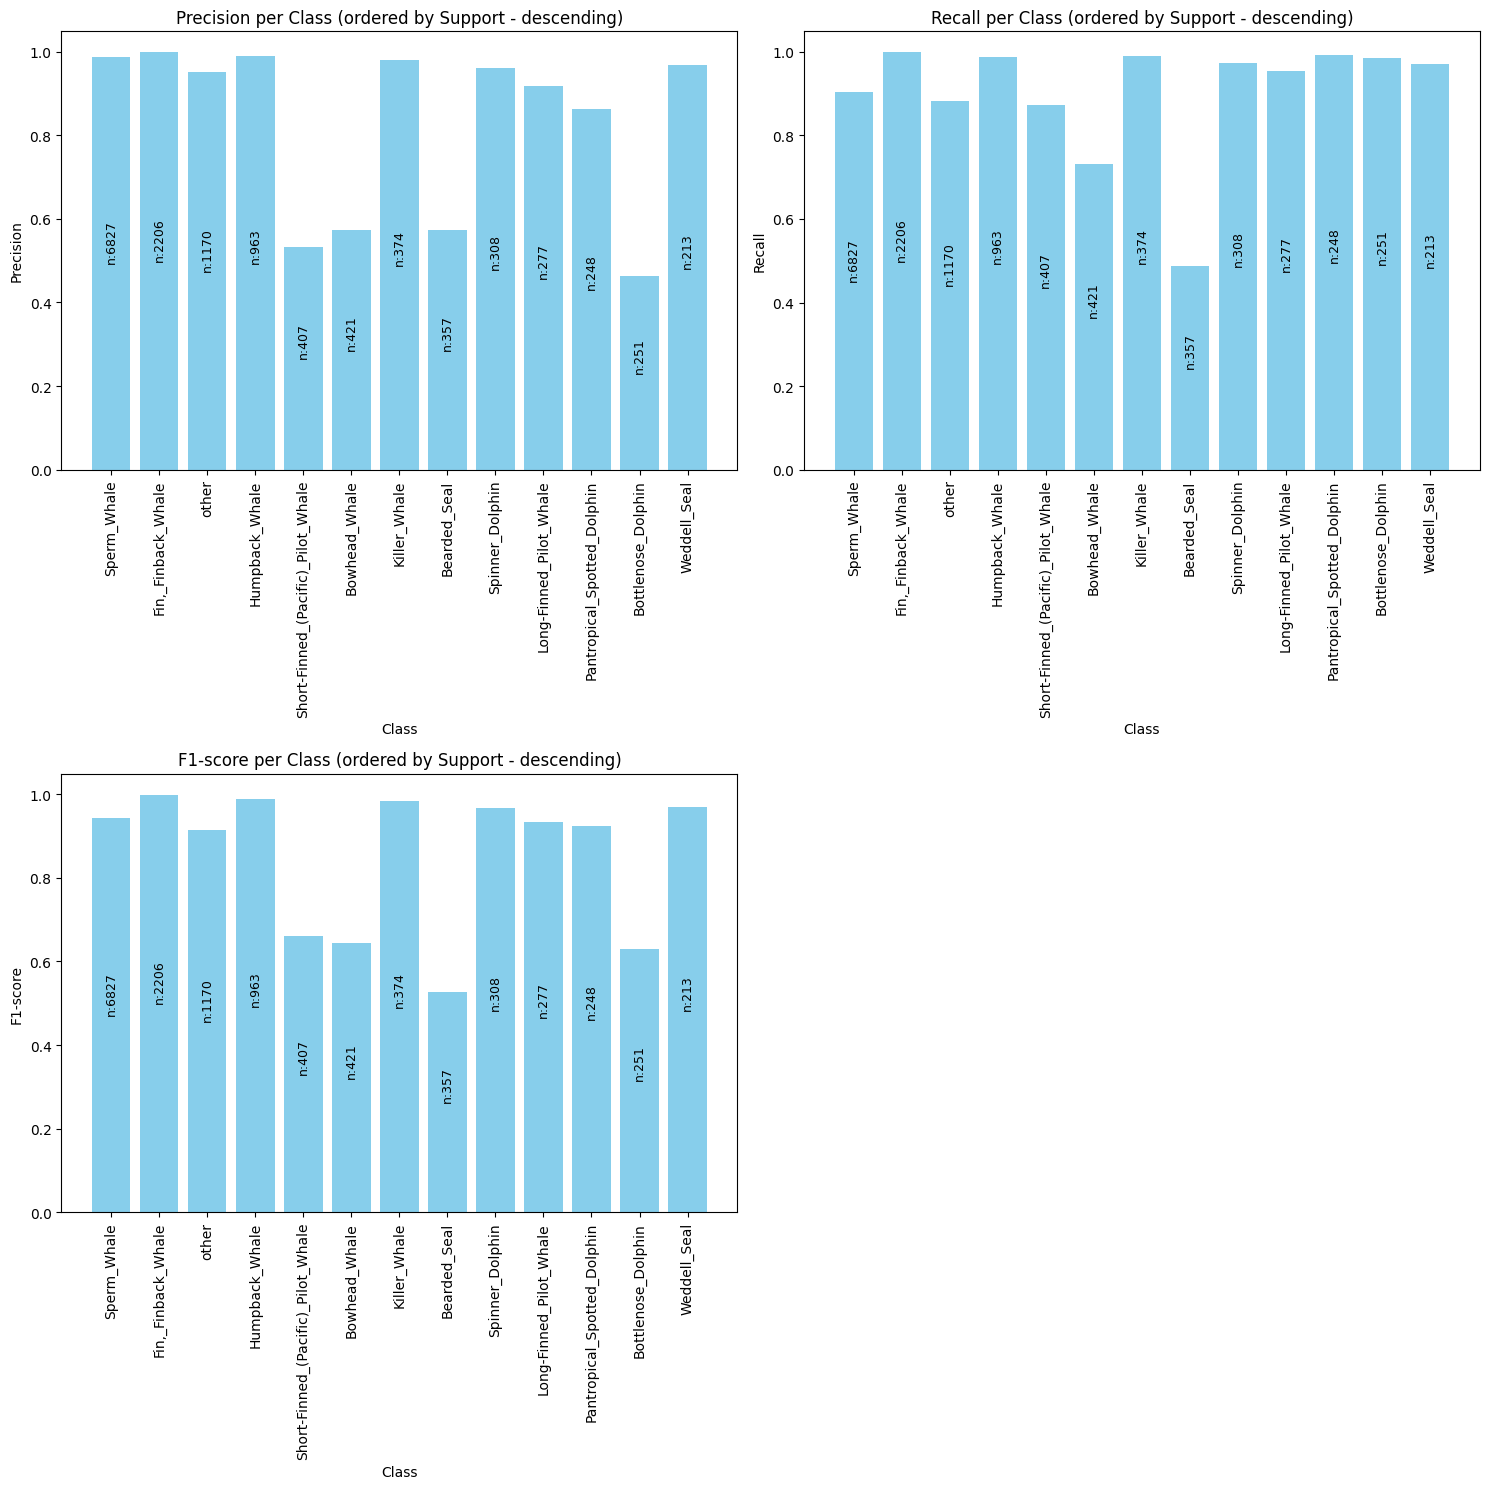

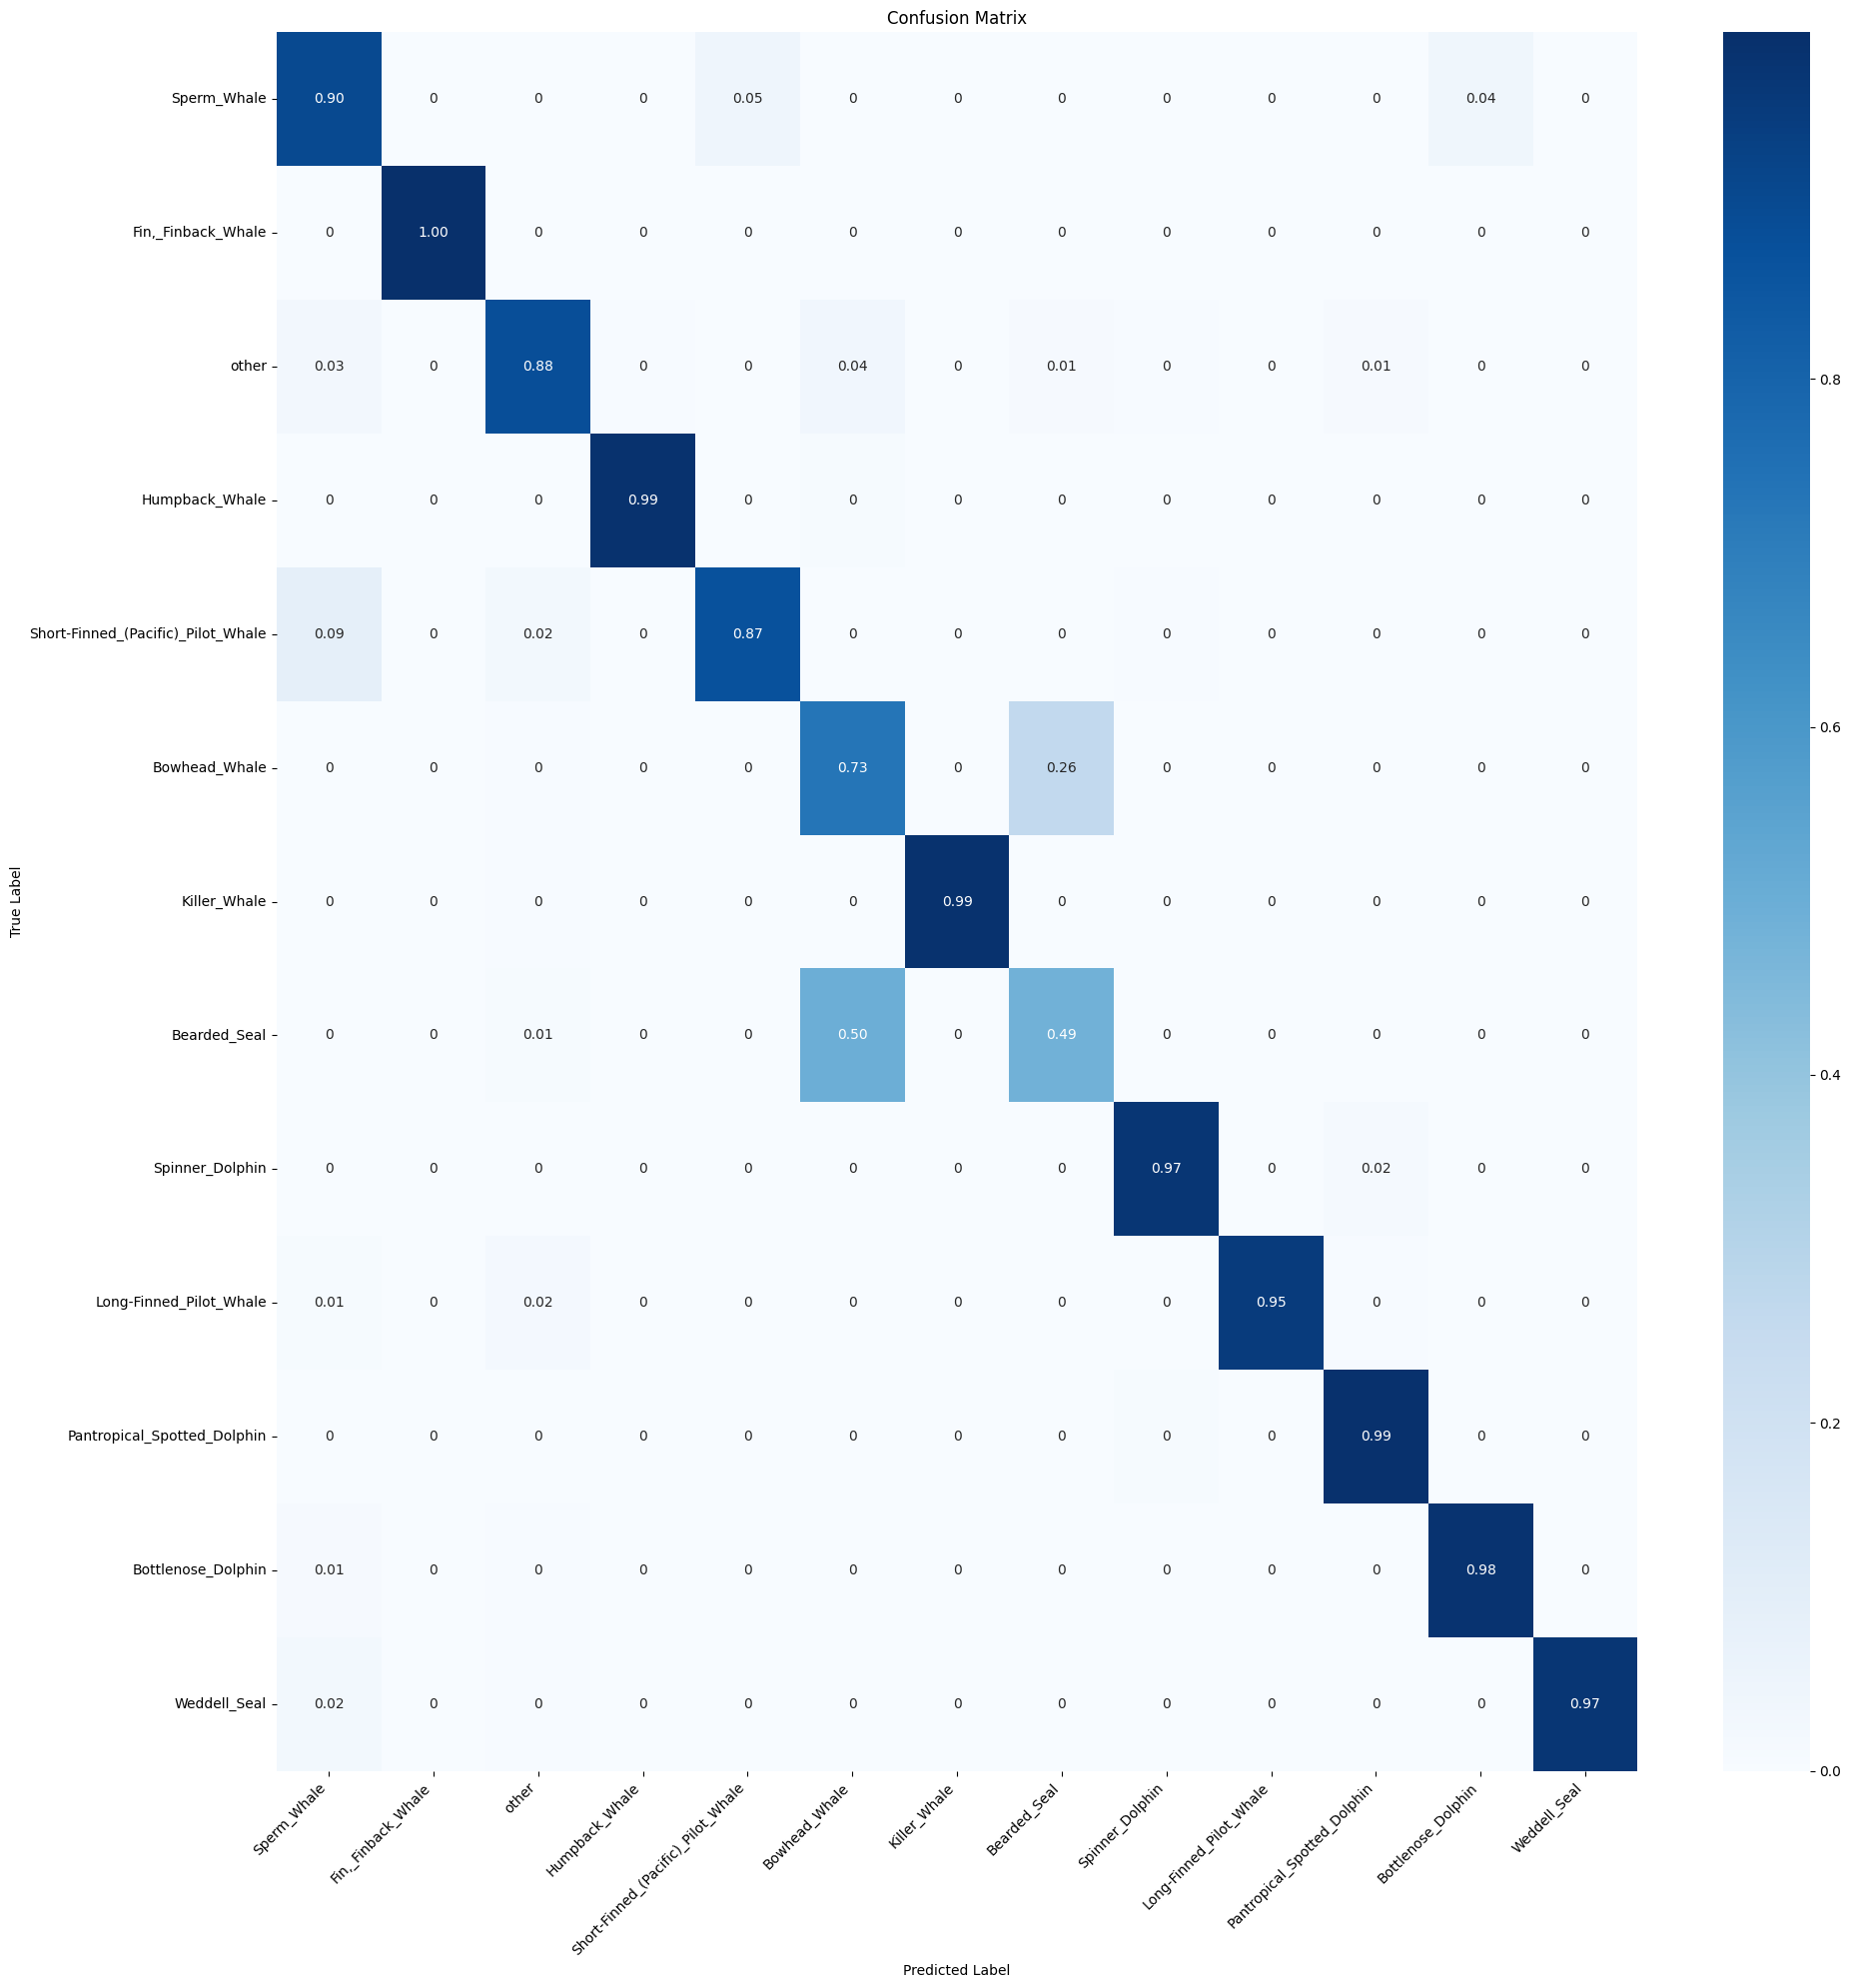

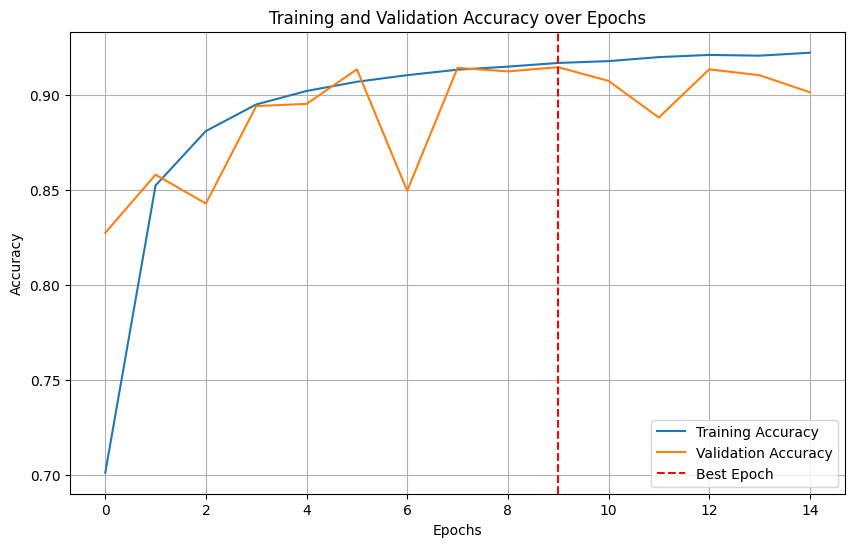

In [10]:
curr_training_date = '14-10'
process_metrics(count_df, 13, os.path.join(MODELS_METRICS_DIR, f'{curr_training_date}_training'), MODELS_METRICS_DIR)

In [2]:
config = {
    "data.dataset": "mammals_calls",
    "data.split": "custom",
    "data.train_way": 4,
    "data.train_support": 2,
    "data.train_query": 3,
    "data.test_way": 4,
    "data.test_support": 2,
    "data.test_query": 3,
    "data.episodes": 10,
    "data.gpu": 0,
    "data.cuda":True,
    "model.x_dim": "164,397,3",
    "model.z_dim": 64,
    "train.epochs": 50,
    'train.optim_method': "Adam",
    "train.lr": 0.001,
    "train.patience": 5,
    "model.save_path": 'data_cache/proto/test_mammals_calls.keras'
}

train(config)

I0000 00:00:1760461912.958160   83031 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2217 MB memory:  -> device: 0, name: NVIDIA RTX 4000 Ada Generation, pci bus id: 0000:18:00.0, compute capability: 8.9


Loaded 2 splits with 4 classes each.
Training started.
Epoch 1 started.
support shape: (4, 2, 164, 397, 3), query shape: (4, 3, 164, 397, 3)
z_prototypes shape: (4, 96), z_query shape: (12, 96)
support shape: (4, 2, 164, 397, 3), query shape: (4, 3, 164, 397, 3)
z_prototypes shape: (4, 96), z_query shape: (12, 96)


2025-10-14 17:12:14.825097: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91301


support shape: (4, 2, 164, 397, 3), query shape: (4, 3, 164, 397, 3)
z_prototypes shape: (4, 96), z_query shape: (12, 96)
Epoch 1 ended.
Epoch 2, Loss: 1.351137399673462, Accuracy: 45.833335876464844, Val Loss: 1.3343786001205444, Val Accuracy: 47.22221374511719
Saving new best model with loss: 1.3343786
Epoch 2 started.
Epoch 2 ended.
Epoch 3, Loss: 1.3516770601272583, Accuracy: 37.5, Val Loss: 1.235568642616272, Val Accuracy: 48.240745544433594
Saving new best model with loss: 1.2355686
Epoch 3 started.
Epoch 3 ended.
Epoch 4, Loss: 1.2341985702514648, Accuracy: 45.83333206176758, Val Loss: 1.2415342330932617, Val Accuracy: 50.277774810791016
Epoch 4 started.
Epoch 4 ended.
Epoch 5, Loss: 1.2876389026641846, Accuracy: 45.0, Val Loss: 1.2065825462341309, Val Accuracy: 51.01850128173828
Saving new best model with loss: 1.2065825
Epoch 5 started.
Epoch 5 ended.
Epoch 6, Loss: 1.2739546298980713, Accuracy: 46.666664123535156, Val Loss: 1.210749864578247, Val Accuracy: 50.37035369873047
E